# <b> Pairs Trading Strategy </b>
Members: Tra Phuong Luu & Phuong Thuy Nguyen

____
# <b> What is pair trading? </b>

### Definition
Pair trading is a trading strategy in which a trader selects two highly cointegrated stocks, taking a long position in one and a short position in the other to minimize market risk and profit from their price convergence.

### Strategy
A trade is executed when there is a significant deviation in the price relationship between the paired stocks. In this scenario, one stock is identified as underperforming, while the other is overperforming. The strategy involves taking a long position in the underperforming stock and a short position in the overperforming stock, anticipating a return to their historical price relationship.


In [7]:
!pip install statsmodels --user
!pip install tensorboardX --user
!pip install pandas==0.24.2 --user
!pip install plotly
!pip install bs4 --user
!pip install plotly --user
!pip install -U auquan_toolbox --user



  Using cached pandas-0.24.2.tar.gz (11.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      C:\Users\ADMIN\AppData\Local\Temp\pip-install-y9tqw3ec\pandas_e4ee3da0765d429b9741cec6c2c1e478\setup.py:12: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        import pkg_resources
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\ADMIN\AppData\Local\Temp\pip-install-y9tqw3ec\pandas_e4ee3da0765d429b9741cec6c2c1e478\setup.py", line 732, in <module>
          version=versioneer.get_version(),
                  ^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\ADMIN\AppData\Local\Temp\pip-install-y9tqw3ec\pandas_e4ee3da0765d429b9741cec6c2c1e478\versioneer.py", line 1409, in get_version
          return get_versions()["version"]
                 ^^^^^^^^^^^

Defaulting to user installation because normal site-packages is not writeable
  Using cached auquan_toolbox-2.1.92-py3-none-any.whl.metadata (476 bytes)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sb
import matplotlib.pyplot as plt


We will use 20 stocks from the Technology sector and 10 years of data for pair trading, as it is suitable for long-term trading.  

Because:  
- Short-term pair trading is risky due to market noise, false signals, and high costs.  
- Long-term pair trading works better because it relies on cointegration, stable statistical indicators, and macroeconomic trends.  
- Institutions favor long-term strategies to reduce transaction costs and maximize profitability.  


In [9]:
start_date = '2014-12-01'
end_date = '2024-10-01'
tech_stock = ["MSFT", "AAPL", "META", "AMZN", "NVDA", "GOOG", "TSLA", "TSM", "AVGO", "BABA", "IBM", "ORCL", "NFLX", "SONY", "ADBE", "PLTR", "CRM", "CSCO", "AMD", "QCOM"]
data = yf.download(tech_stock , start=start_date, end=end_date, interval = '1d', auto_adjust=False)['Adj Close']
data.index = data.index.strftime('%Y-%m-%d')
data.dropna()
data = data.fillna(method='bfill')
data.head()



[*********************100%***********************]  20 of 20 completed
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26452\1737045981.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill')


Ticker,AAPL,ADBE,AMD,AMZN,AVGO,BABA,CRM,CSCO,GOOG,IBM,META,MSFT,NFLX,NVDA,ORCL,PLTR,QCOM,SONY,TSLA,TSM
Date,,,,,,,,,,,,,,,,,,,,
2014-12-01,25.597292,73.750000,2.67,16.299999,6.907096,102.359482,58.751850,20.036633,26.491447,99.671288,74.747711,41.666107,48.830002,0.493899,35.942036,9.5,53.401123,3.868257,15.442667,17.355236
2014-12-02,25.499420,73.470001,2.68,16.315500,7.002029,106.125900,58.920902,20.203667,26.488966,100.368515,75.106018,41.528976,50.330002,0.494619,36.027454,9.5,54.539223,3.835076,15.428667,17.075310
2014-12-03,25.788595,73.180000,2.74,15.825000,7.224541,106.850212,58.552959,20.298079,26.368372,101.509956,74.528740,41.203335,50.731430,0.507338,35.924973,9.5,55.320255,3.833329,15.286667,17.347664
2014-12-04,25.690723,73.029999,2.69,15.846500,7.827539,105.430557,58.622570,20.167360,26.665642,101.219986,74.887054,41.854649,50.085712,0.502778,35.779762,9.5,54.554096,3.863018,15.218667,17.264450
2014-12-05,25.581718,72.400002,2.66,15.631500,7.897407,104.204063,58.523121,19.971268,26.067623,100.738724,76.001808,41.494717,50.131428,0.505658,35.813915,9.5,54.576412,3.870003,14.914000,17.203920


 ---
 <h2><b> What is the Engle-Granger Cointegration Test? </b></h2>

The Engle-Granger Cointegration Test is a statistical method used to determine whether two or more time series  share a long-term equilibrium relationship.

In Pair Trading, cointegration is essential because it ensures that two stocks move together over time, even if they experience short-term deviations.

`Step 1`: We assume that two stocks Stock1 (S1) and Stock2 (S2) have the following relationship:

$$
S1_t = \alpha + \beta S2_t + \epsilon_t
$$

`Step 2`: Check for Stationarity of the Residuals
- If the residuals are not stationary, the two stocks are not cointegrated
- If the residuals are sationary, then the spread between the two stocks will revert to the mean

`Step 3`: Compute the P-value
- The Engle-Granger test returns a p-value, which tells us whether the residuals are sationary
- If the p-value < 0.05 => We reject the null Hypothesis (no cointegration) and conclude that the stocks are cointegrated





---

<h2> find_cointegrated_pairs() </h2>

This function identifies cointegrated stock pairs from a dataset using the Engle-Granger cointegration test. Cointegrated pairs are essential for pair trading, as they tend to move together over time, making them suitable for mean reversion strategies.

`Step 1`: We intitilized variables

`Step 2`: We looped through all stock pairs

`Step 3`: We extracted stock prices and handle missing value by dropping NaN values to prevent errors in the cointergration test. We also skipped testing if either stock has less than 10 time-point, which may make the test unreliable.

`Step 4`: We ran the Engle-Granger Cointegration Test (coint()) on the stock pair and stored the cointegration test score and p-value in matrices.

`Step 5`: If p-value < 0.05, it means the stocks are cointegrated (they move together over time), then we added the stock pair to the pairs list

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26452\1705223119.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


P-value for MSFT and AAPL: 0.93047
P-value for MSFT and META: 0.03787
P-value for MSFT and AMZN: 0.84570
P-value for MSFT and NVDA: 0.94466
P-value for MSFT and GOOG: 0.99184
P-value for MSFT and TSLA: 0.65755
P-value for MSFT and TSM: 0.78726
P-value for MSFT and AVGO: 0.22875
P-value for MSFT and BABA: 0.54052
P-value for MSFT and IBM: 0.67772
P-value for MSFT and ORCL: 0.06587
P-value for MSFT and NFLX: 0.86177
P-value for MSFT and SONY: 0.83950
P-value for MSFT and ADBE: 0.62880
P-value for MSFT and PLTR: 0.62772
P-value for MSFT and CRM: 0.07736
P-value for MSFT and CSCO: 0.76216
P-value for MSFT and AMD: 0.61735
P-value for MSFT and QCOM: 0.38427
P-value for AAPL and META: 0.28314
P-value for AAPL and AMZN: 0.00674
P-value for AAPL and NVDA: 0.92133
P-value for AAPL and GOOG: 0.89127
P-value for AAPL and TSLA: 0.00135
P-value for AAPL and TSM: 0.16477
P-value for AAPL and AVGO: 0.39453
P-value for AAPL and BABA: 0.78342
P-value for AAPL and IBM: 0.91208
P-value for AAPL and ORCL:

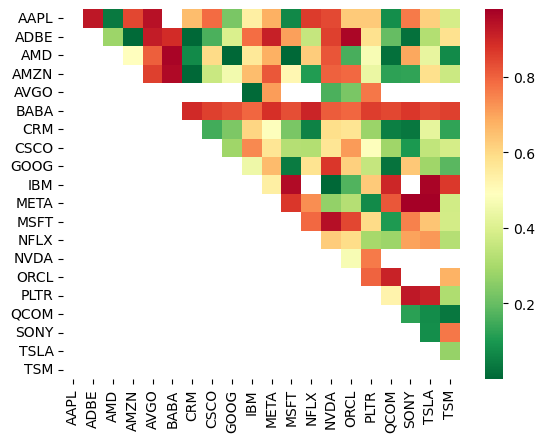

Cointegrated Pairs: [('AAPL', 'AMD'), ('ADBE', 'AMZN'), ('ADBE', 'CRM'), ('ADBE', 'SONY'), ('AMD', 'GOOG'), ('AMD', 'MSFT'), ('AMD', 'QCOM'), ('AMZN', 'CRM'), ('AVGO', 'IBM'), ('CRM', 'QCOM'), ('CRM', 'SONY'), ('GOOG', 'MSFT'), ('GOOG', 'QCOM'), ('IBM', 'NVDA'), ('QCOM', 'TSM')]


In [10]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    scores = np.zeros((n, n))
    pvalues = np.ones((n, n))
    pairs = []

    for i in range(n):
        for j in range(i+1, n):
            stock1 = data.iloc[:, i]
            stock2 = data.iloc[:, j]
         
            stock1 = stock1.dropna()
            stock2 = stock2.dropna()
           
            if len(stock1) < 10 or len(stock2) < 10:
                continue
            score, pvalue, _ = coint(stock1, stock2)
            scores[i, j] = score
            pvalues[i, j] = pvalue

            if pvalue < 0.05:
                pairs.append((data.columns[i], data.columns[j]))

    return scores, pvalues, pairs


data = data.fillna(method='ffill').fillna(method='bfill')
scores, pvalues, pairs = find_cointegrated_pairs(data)


for i, stock1 in enumerate(tech_stock):
    for j, stock2 in enumerate(tech_stock):
        if i < j:
            print(f"P-value for {stock1} and {stock2}: {pvalues[i, j]:.5f}")

tech_stock = list(data.columns)


sb.heatmap(pvalues, xticklabels=tech_stock,
           yticklabels=tech_stock, cmap='RdYlGn_r',
           mask=(pvalues >= 0.98))
plt.show()


print("Cointegrated Pairs:", pairs)

The purpose of the above code is to identify and analyze pairs of cointegrated stocks from a given dataset.

For each identified pair, the code computed the price ratio (Stock1 / Stock2). The ratio was then plotted over time to visualize deviations from the mean, helping traders spot potential trading opportunities. Additionally, the mean ratio and p-value from the cointegration test were displayed, providing insights into the statistical relationship between the two stocks. The final visualization aided in assessing whether the pair was suitable for mean reversion trading strategies.

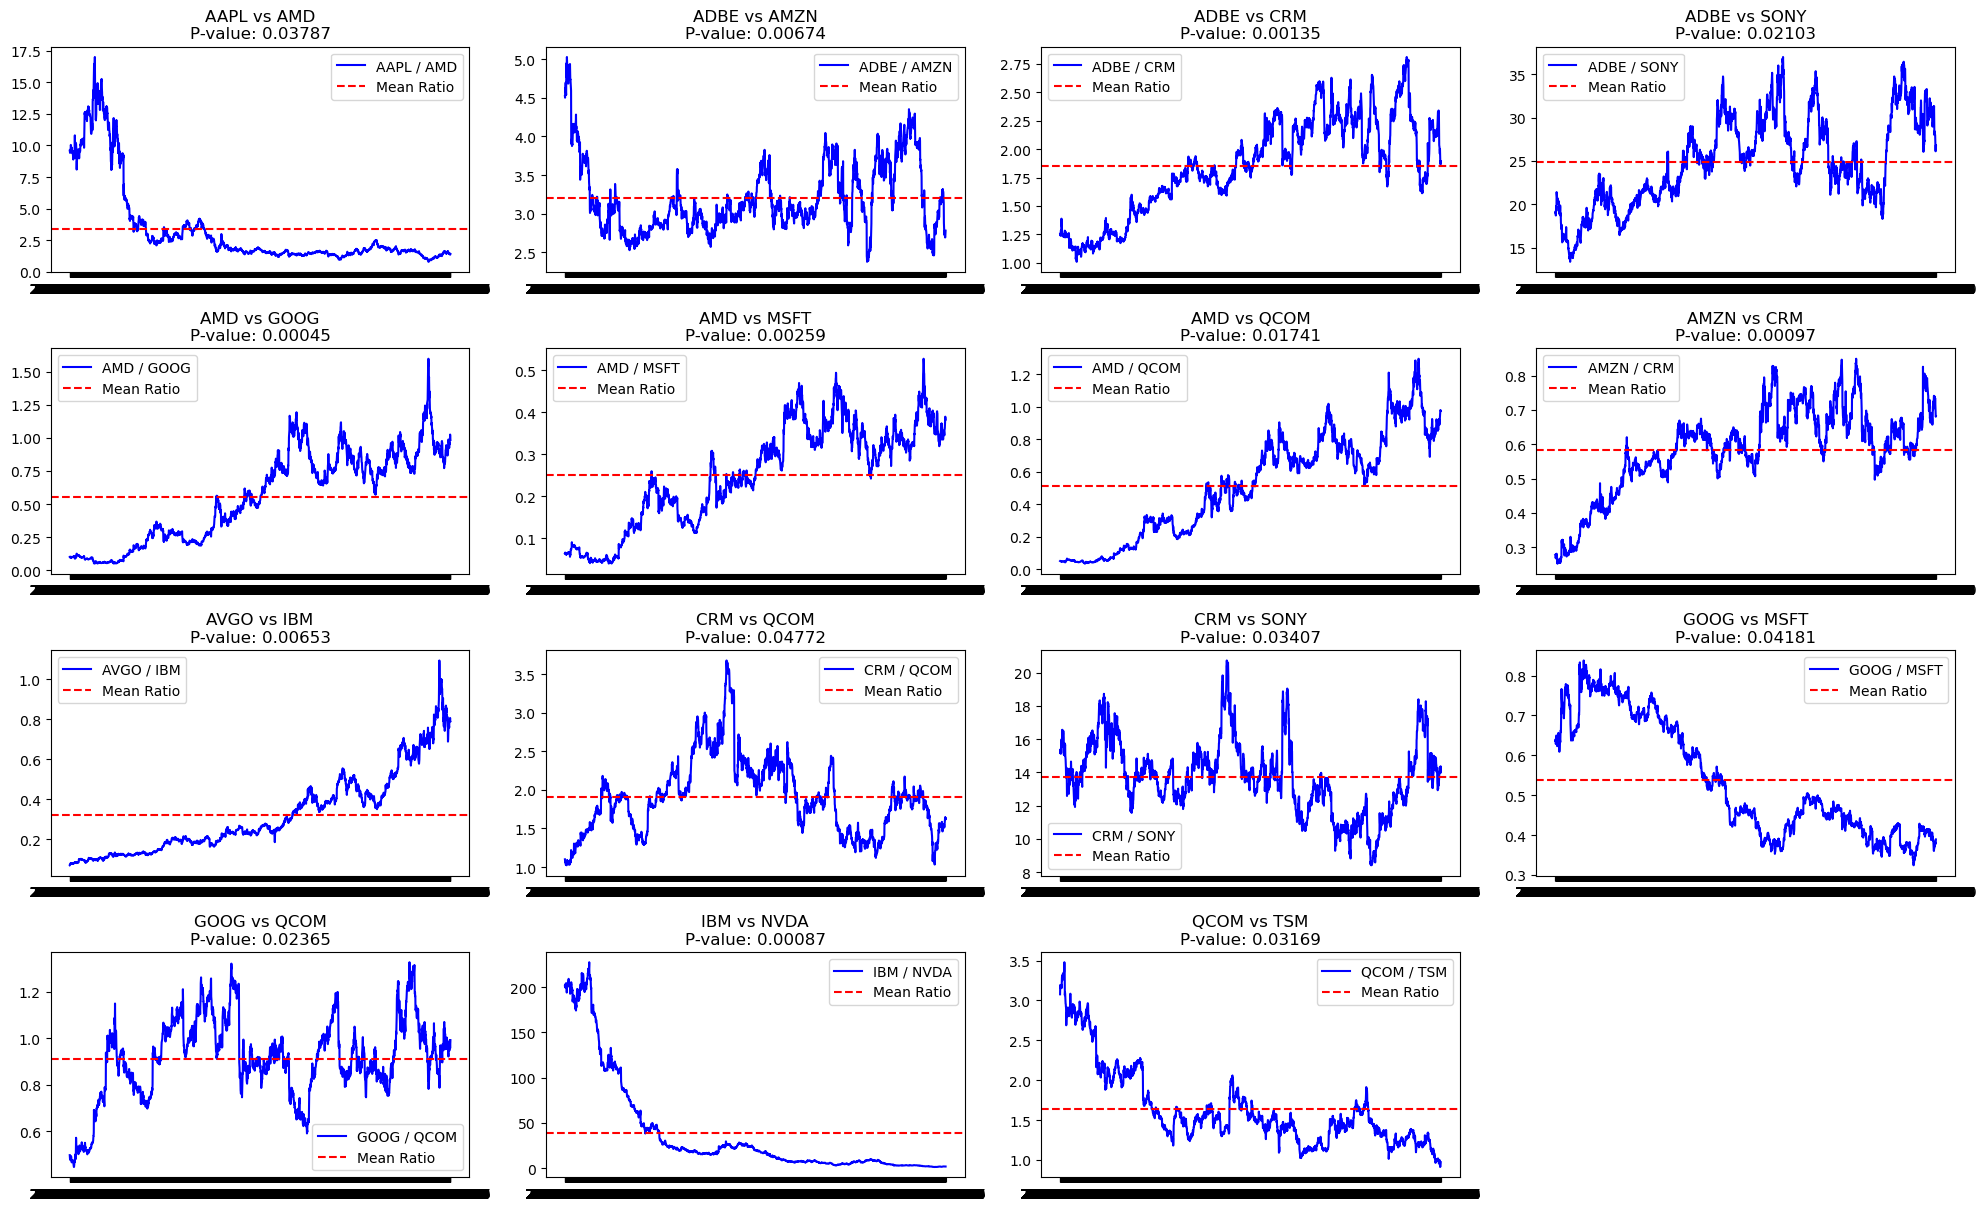

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint


data_stock = pairs

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
axes = axes.flatten()

for i in range(len(data_stock)):
    stock1 = data[data_stock[i][0]]
    stock2 = data[data_stock[i][1]]


    score, pvalue, _ = coint(stock1, stock2)


    ratio = stock1 / stock2

    # Plot ratio
    ax = axes[i]
    ax.plot(ratio, label=f'{data_stock[i][0]} / {data_stock[i][1]}', color='b')
    ax.axhline(ratio.mean(), color='r', linestyle='--', label='Mean Ratio')

    ax.set_title(f"{data_stock[i][0]} vs {data_stock[i][1]}\nP-value: {pvalue:.5f}")
    ax.legend()


for j in range(len(data_stock), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()





After observing, we decided to choose `GOOG` and `QCOM` based on the following key factors:
- The price ratio fluctuated around the mean (dashed line)
- There were several deviation from the mean where the ratio moves far above or below, indicating potential trading opportunities
- The ratio exhibited clear up and down movements instead of trending in one direction
- High volatility around the mean is good because it provides multiple trading signals when the ratio moves too high(short trade) or too low (long trade)

---
<h2>Zscore</h2>

Next, we computed the z-score of a given time series. The z-score standardized the ratio, allowing us to detect when the price ratio deviates significantly from its mean. 
- **Formula:**  
  $$ Z = \frac{X - \mu}{\sigma} $$

The purpose of the Z-score:
- The z-score is used to measure how far a data point deviates from the mean expressed in terms of standard deviations
- It helps identify extreme values or deviations from the normal behavior in a time series
- Z-score Standardization: The formula scales the data, making it easier to detect outliers and unusual movements

<b> Why it matters in Pair Trading? </b>
- The z-score of the price ratio helps determine when the ratio is too high or too low

In this Strategy:

- ` Z > 1 ` →  We short Stock1 and buy Stock2, expecting the ratio to revert down.

- `Z < -1 `→ We buy Stock1 and short Stock2, expecting the ratio to revert up.
  
- `0.5 < Z < 0.5` → No significant deviation, meaning we exit all positions as the spread has returned to its normal level.

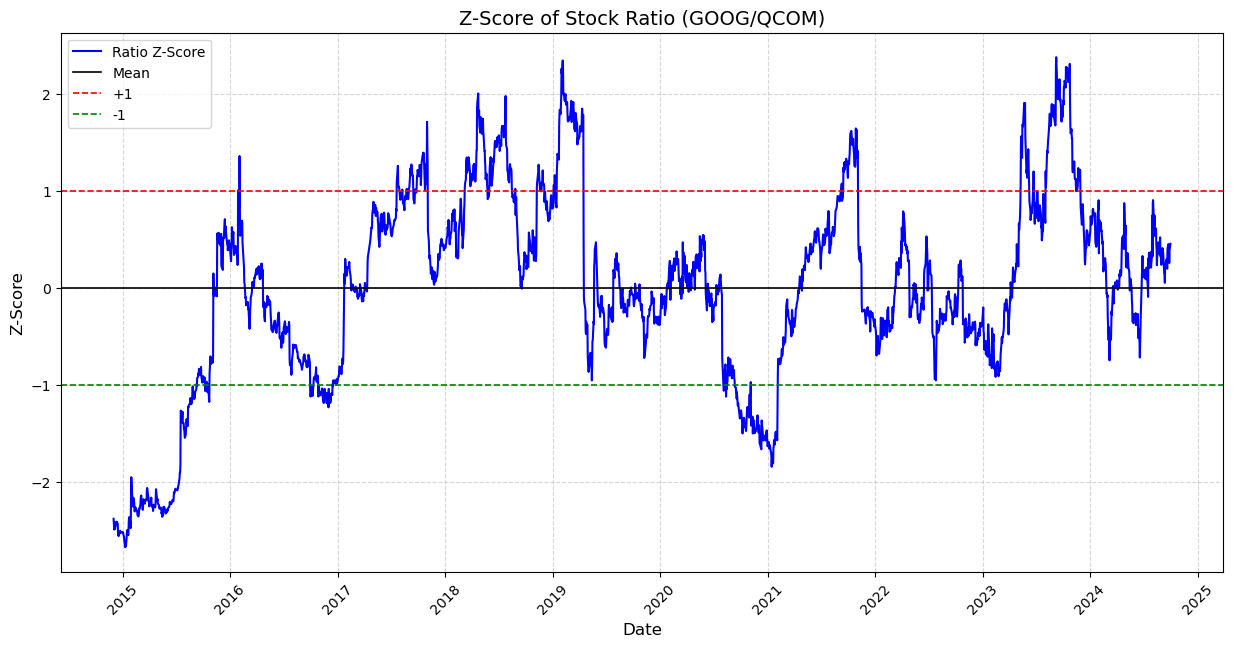

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Ensure the data index is a DateTime index
data.index = pd.to_datetime(data.index) 

# Compute Ratio
stock1 = data["GOOG"]
stock2 = data["QCOM"]
ratio = stock1 / stock2

# Ensure Ratio has the Correct Date Index
ratio = pd.Series(ratio, index=data.index)

# Compute Z-Score
def zscore(series):
    return (series - series.mean()) / series.std()

ratio_zscore = zscore(ratio)

# Create Plot
plt.figure(figsize=(15, 7))

# Plot Z-Score Ratio
plt.plot(ratio_zscore.index, ratio_zscore.values, color="blue", linewidth=1.5, label="Ratio Z-Score")

# Plot Mean and Threshold Lines
plt.axhline(0, color="black", linewidth=1.2, label="Mean")
plt.axhline(1.0, linestyle="dashed", color="red", linewidth=1.2, label="+1")
plt.axhline(-1.0, linestyle="dashed", color="green", linewidth=1.2, label="-1")

# Format x-axis with Yearly Ticks
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.xticks(rotation=45)  

# Labels & Grid
plt.title("Z-Score of Stock Ratio (GOOG/QCOM)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Z-Score", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Legend Placement
plt.legend(fontsize=10, loc="upper left")

# Show Plot
plt.show()

In [13]:
ratio = stock1/stock2
ratio

Date
2014-12-01    0.496084
2014-12-02    0.485687
2014-12-03    0.476649
2014-12-04    0.488793
2014-12-05    0.477635
                ...   
2024-09-24    0.988365
2024-09-25    0.976717
2024-09-26    0.956789
2024-09-27    0.979671
2024-09-30    0.991398
Length: 2474, dtype: float64

<h2>Moving Averages and Standard Deviation</h2>
- We computed the Z-score for the ratio. This measured how much the short-term moving average deviates from the long-term mean in terms of standard deviations.
  
- `zscore_60_5` > 1 -> The ratio above its mean -> short signal
  
- `zscore_60_5` < 1 -> The ratio below its mean -> long signal


Start Date: 2014-12-01


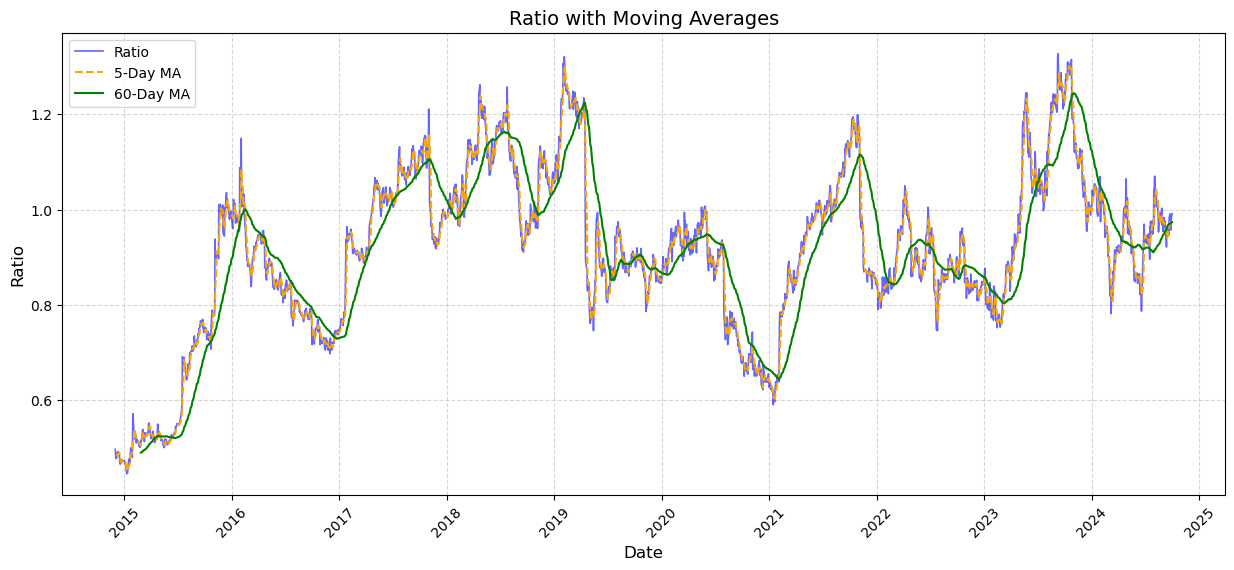

In [14]:

import matplotlib.dates as mdates

if not isinstance(ratio.index, pd.DatetimeIndex):
    ratio.index = pd.to_datetime(ratio.index)  

# Compute Moving Averages
ratio_mavg5 = ratio.rolling(window=5, center=False).mean()
ratio_mavg60 = ratio.rolling(window=60, center=False).mean()

# Compute Standard Deviation & Z-Score
std_60 = ratio.rolling(window=60, center=False).std()
zscore_60_5 = (ratio_mavg5 - ratio_mavg60) / std_60

# Extract the Start Date
start_date = ratio.index.min() 
print(f"Start Date: {start_date.strftime('%Y-%m-%d')}")  

# Create Plot
plt.figure(figsize=(15, 6))

# Plot Ratio and Moving Averages with Distinct Styling
plt.plot(ratio.index, ratio.values, color="blue", alpha=0.6, linewidth=1.2, label="Ratio")
plt.plot(ratio_mavg5.index, ratio_mavg5.values, linestyle="dashed", color="orange", linewidth=1.5, label="5-Day MA")
plt.plot(ratio_mavg60.index, ratio_mavg60.values, linestyle="solid", color="green", linewidth=1.5, label="60-Day MA")

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.xticks(rotation=45)  

# Labels & Grid
plt.title(f"Ratio with Moving Averages", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ratio", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Legend Positioning
plt.legend(fontsize=10, loc="upper left")

# Show Plot
plt.show()

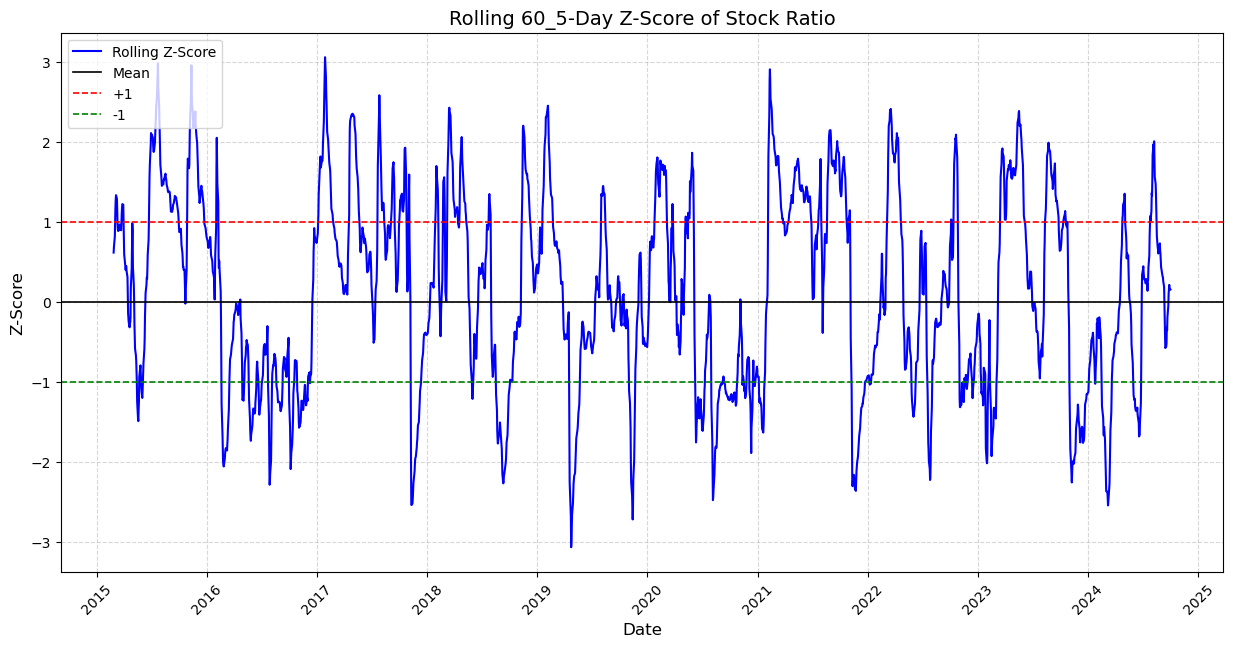

In [15]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


if not isinstance(ratio.index, pd.DatetimeIndex):
    ratio.index = pd.to_datetime(ratio.index) 

# Take a rolling 60-day standard deviation
std_60 = ratio.rolling(window=60, center=False).std()
std_60.name = '60-Day Std Dev'

# Compute the rolling Z-score
zscore_60_5 = (ratio_mavg5 - ratio_mavg60) / std_60
zscore_60_5.name = 'Rolling Z-Score'

# Create Plot
plt.figure(figsize=(15, 7))

# Plot Rolling Z-Score
plt.plot(zscore_60_5.index, zscore_60_5.values, color="blue", linewidth=1.5, label="Rolling Z-Score")

# Plot Mean and Threshold Lines
plt.axhline(0, color="black", linewidth=1.2, label="Mean")
plt.axhline(1.0, linestyle="dashed", color="red", linewidth=1.2, label="+1")
plt.axhline(-1.0, linestyle="dashed", color="green", linewidth=1.2, label="-1")

# Format x-axis with Yearly Ticks
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.xticks(rotation=45)  

# Labels & Grid
plt.title("Rolling 60_5-Day Z-Score of Stock Ratio", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Z-Score", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Legend Placement
plt.legend(fontsize=10, loc="upper left")

# Show Plot
plt.show()

<h2>Buy and sell signal graph </h2>
The graph visualizes the trading signals for a pair trading strategy based on the z-score of the price ratio between two stocks.
- Blue Line (Ratio): Represents the price ratio of the two stocks over time.
  
- Green Markers (Buy Signal): These indicate points where the z-score dropped below -1, signaling that the pair is undervalued, and we should buy stock1 and short stock2.

- Red Markers (Sell Signal): These indicate points where the z-score rose above +1, signaling that the pair is overvalued, and we should short stock1 and buy stock2.

<b>How this work in Pair Trading?</b>
- When the price ratio deviates significantly from its historical mean (determined by the z-score threshold), we take advantage of the mean reversion property.
  
- The strategy profits when the ratio returns to its historical mean, at which point we exit our positions.



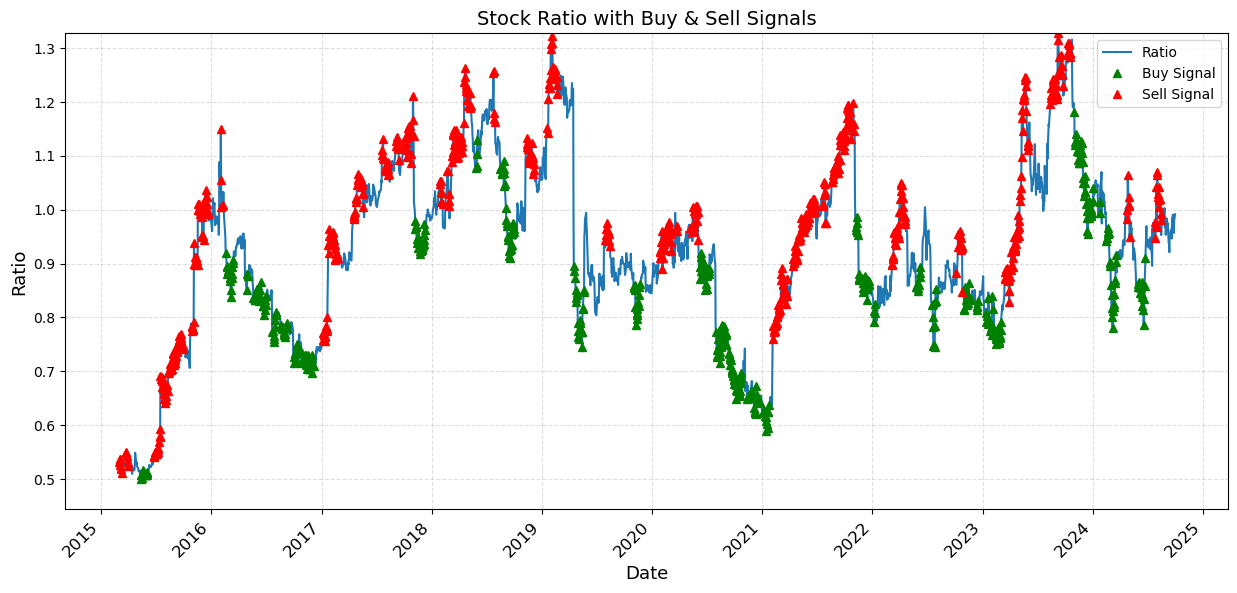

In [16]:
plt.figure(figsize=(15,7))

ratio[60:].plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratio.min(),ratio.max()))
# Format x-axis với Yearly Ticks
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.xticks(rotation=45, fontsize=12)

# Labels & Grid nhẹ
plt.title("Stock Ratio with Buy & Sell Signals", fontsize=14)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Ratio", fontsize=13)
plt.grid(True, linestyle="--", alpha=0.4)  # Grid nhẹ
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

In [17]:
import pandas as pd
import numpy as np
first_valid_idx = zscore_60_5.first_valid_index()
zscore_60_5 = zscore_60_5[first_valid_idx:]
zscore_60_5= zscore_60_5.dropna()



# <b> Trading strategy </b>

### Overall strategy

Trading begins when the z-score moves beyond the set threshold (greater than 1 or less than -1). The position is closed when the z-score returns to a normal level (threshold of 0.5 or -0.5).

> If the z-score is greater than 1, we short Stock 1 and long Stock 2, closing the trade when the z-score reaches 0.5.
> 
> If the z-score is less than -1, we long Stock 1 and short Stock 2, closing the trade when the z-score reaches -0.5.

### Detail strategy

**Money Allocation:**

Funds are split equally between the long position stock and the short position stock to maintain a balanced trade.


**Trading amount:**
- `Long Position Stock`: Use the allocated long position fund to buy the maximum amount of the stock.
- `Short Position Stock`: Short the stock in proportion to the amount purchased in the long position.


**Why short position stock depends on long position stock?:**

The ratio is used to balance the risk exposure between two stocks in a pair trading strategy. It accounts for the relative price movement sensitivity between the two stocks. If one stock tends to move twice as much as the other, simply allocating equal capital will not hedge the portfolio properly. Instead, we adjust the number of shares traded based on the ratio to ensure that gains and losses offset each other, creating a market-neutral position.

**Money calculation:**

- At trade entry: Paying trading fee for 2 trades (assuming a fee value of $10 for simplicity)
- At trade exit: Receiving proceeds from the long position stock sale, paying for covering the short position stock and paying an additional trading fee for two trades.
- **Formula:**  
  $$ Money = Money + Long\ position\ stock's\ proceeds - Short\ position\ stock's\ payment - Trading\ fees $$


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

entry_threshold = 1.0
exit_threshold = 0.5
money = 10000  
fee = 10
stock1_position = 0
stock2_position = 0
stock1 = data["GOOG"]
stock2 = data["QCOM"]

# Đồng bộ index của tất cả dữ liệu
zscore_60_5 = zscore_60_5.reindex(stock1.index)




for i in range(1, len(zscore_60_5)):
    if zscore_60_5[i] < - entry_threshold and stock1_position == 0:
        money -= fee*2
        capital_per_stock = money / 2
        stock2_position = - (capital_per_stock / stock2[i]) 
        stock1_position = (capital_per_stock / stock1[i]) / ratio[i]


    elif zscore_60_5[i] > entry_threshold and stock1_position == 0:
        money -= fee*2
        capital_per_stock = money / 2
        stock1_position = - (capital_per_stock / stock1[i]) 
        stock2_position = (capital_per_stock / stock2[i]) * ratio[i]

    
    elif abs(zscore_60_5[i]) < exit_threshold and stock1_position != 0:
        money += stock1_position * stock1[i] + stock2_position * stock2[i] - fee*2
        stock1_position = 0
        stock2_position = 0

print(money)






46445.1742197055


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26452\375122112.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore_60_5[i] < - entry_threshold and stock1_position == 0:
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26452\375122112.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore_60_5[i] > entry_threshold and stock1_position == 0:
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26452\375122112.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

## <b> CONCLUSION </b>
Our pair trading strategy has demonstrated remarkable profitability. Beginning with an initial investment of $10,000, we achieved a final balance of $46,445, marking an impressive return. This confirms that statistical arbitrage, specifically mean reversion trading, can be an effective method for generating profits in financial markets.

Pair trading remains a powerful, data-driven strategy that can be highly profitable when executed with the right risk management and parameter tuning. However, real-world execution challenges such as trading fees, liquidity constraints, and changing market conditions should be carefully accounted for. With continuous optimization, this strategy has the potential to be a consistent money-making tool in both bull and bear markets.